# Vision Language Model

By Alberto Valdés

**Mail 1:** anvaldes@uc.cl

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

This notebook was executed in Google Colab using a A100-GPU

### Star of execution

In [ ]:
import time

In [ ]:
start = time.time()

# 1. Setting the environment

In [ ]:
!pip install -q datasets flash_attn timm einops

# 2. Import Libraries

In [ ]:
import os
import torch
import requests
from tqdm import tqdm
from PIL import Image
from matplotlib import patches
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import AdamW, get_scheduler
from transformers import AutoProcessor, AutoModelForCausalLM
from transformers import AutoModelForCausalLM, AutoProcessor

# 3. Functions

In [ ]:
class DocVQADataset(Dataset):

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        question = "<DocVQA>" + example['question']
        first_answer = example['answers'][0]
        image = example['image'].convert("RGB")
        return question, first_answer, image

In [ ]:
def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(device)
    return inputs, answers

# 4. Load model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Florence-2-base-ft",
    trust_remote_code=True,
    revision='refs/pr/6'
).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base-ft",
    trust_remote_code=True, revision='refs/pr/6')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
for param in model.vision_tower.parameters():
  param.is_trainable = False

# 5. Example

In [ ]:
prompt = "<OD>"

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

In [ ]:
inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)

In [ ]:
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    do_sample=False,
    num_beams=3
)

In [ ]:
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

In [ ]:
parsed_answer = processor.post_process_generation(generated_text, task="<OD>", image_size=(image.width, image.height))

In [ ]:
print(parsed_answer)

{'<OD>': {'bboxes': [[34.880001068115234, 160.55999755859375, 597.4400024414062, 371.7599792480469], [453.44000244140625, 276.7200012207031, 553.9199829101562, 370.79998779296875], [93.75999450683594, 280.55999755859375, 197.44000244140625, 371.2799987792969]], 'labels': ['car', 'wheel', 'wheel']}}


In [ ]:
all_bb = parsed_answer['<OD>']['bboxes']
all_labels = parsed_answer['<OD>']['labels']

In [ ]:
plot_bb = []

for i in range(len(all_bb)):

  bb = all_bb[i]

  x_1 = bb[0]
  y_1 = bb[1]
  x_2 = bb[2]
  y_2 = bb[3]

  x = x_1
  y = y_1

  w = x_2 - x_1
  h = y_2 - y_1

  label = all_labels[i]

  bb_p = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor='r', facecolor='none')

  plot_bb.append(bb_p)

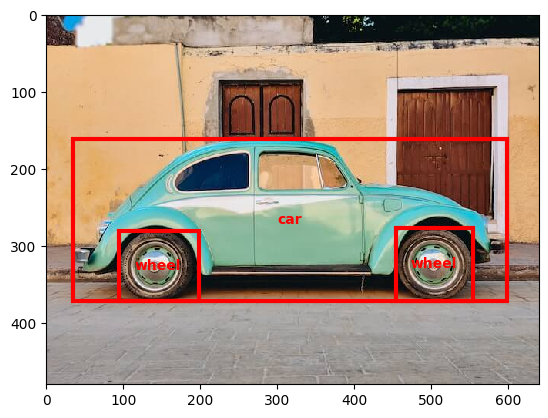

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(111)

ax.imshow(image, cmap = plt.cm.gray, interpolation ='nearest')

for i in range(len(plot_bb)):

  p_bb = plot_bb[i]

  bb = all_bb[i]

  x_1 = bb[0]
  y_1 = bb[1]
  x_2 = bb[2]
  y_2 = bb[3]

  cx = int((x_1 + x_2)/2)
  cy = int((y_1 + y_2)/2)

  ax.add_patch(p_bb)

  ax.annotate(all_labels[i], (cx, cy), color='red', weight='bold', fontsize=10, ha='center', va='center')

plt.show()

# 6. Load Dataset

In [ ]:
train_dataset = DocVQADataset(load_dataset("HuggingFaceM4/DocumentVQA", split = 'train[0:1000]'))

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
val_dataset = DocVQADataset(load_dataset("HuggingFaceM4/DocumentVQA", split = 'validation[0:400]'))

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
batch_size = 6
num_workers = 0

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          collate_fn=collate_fn, num_workers=num_workers, shuffle=True)

In [ ]:
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                          collate_fn=collate_fn, num_workers=num_workers)

# 7. See example

In [ ]:
idx = 10

In [ ]:
prompt = train_dataset[idx][0]
image = train_dataset[idx][2]
result = train_dataset[idx][1]

In [ ]:
prompt

'<DocVQA>Which part of Virginia is this letter sent from'

In [ ]:
inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)

In [ ]:
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    do_sample=False,
    num_beams=3
)

In [ ]:
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

In [ ]:
parsed_answer = processor.post_process_generation(generated_text, task="<DocVQA>", image_size=(image.width, image.height))

In [ ]:
print(parsed_answer)

{'<DocVQA>': 'docvQA'}


### a. Ground Truth

In [ ]:
prompt

'<DocVQA>Which part of Virginia is this letter sent from'

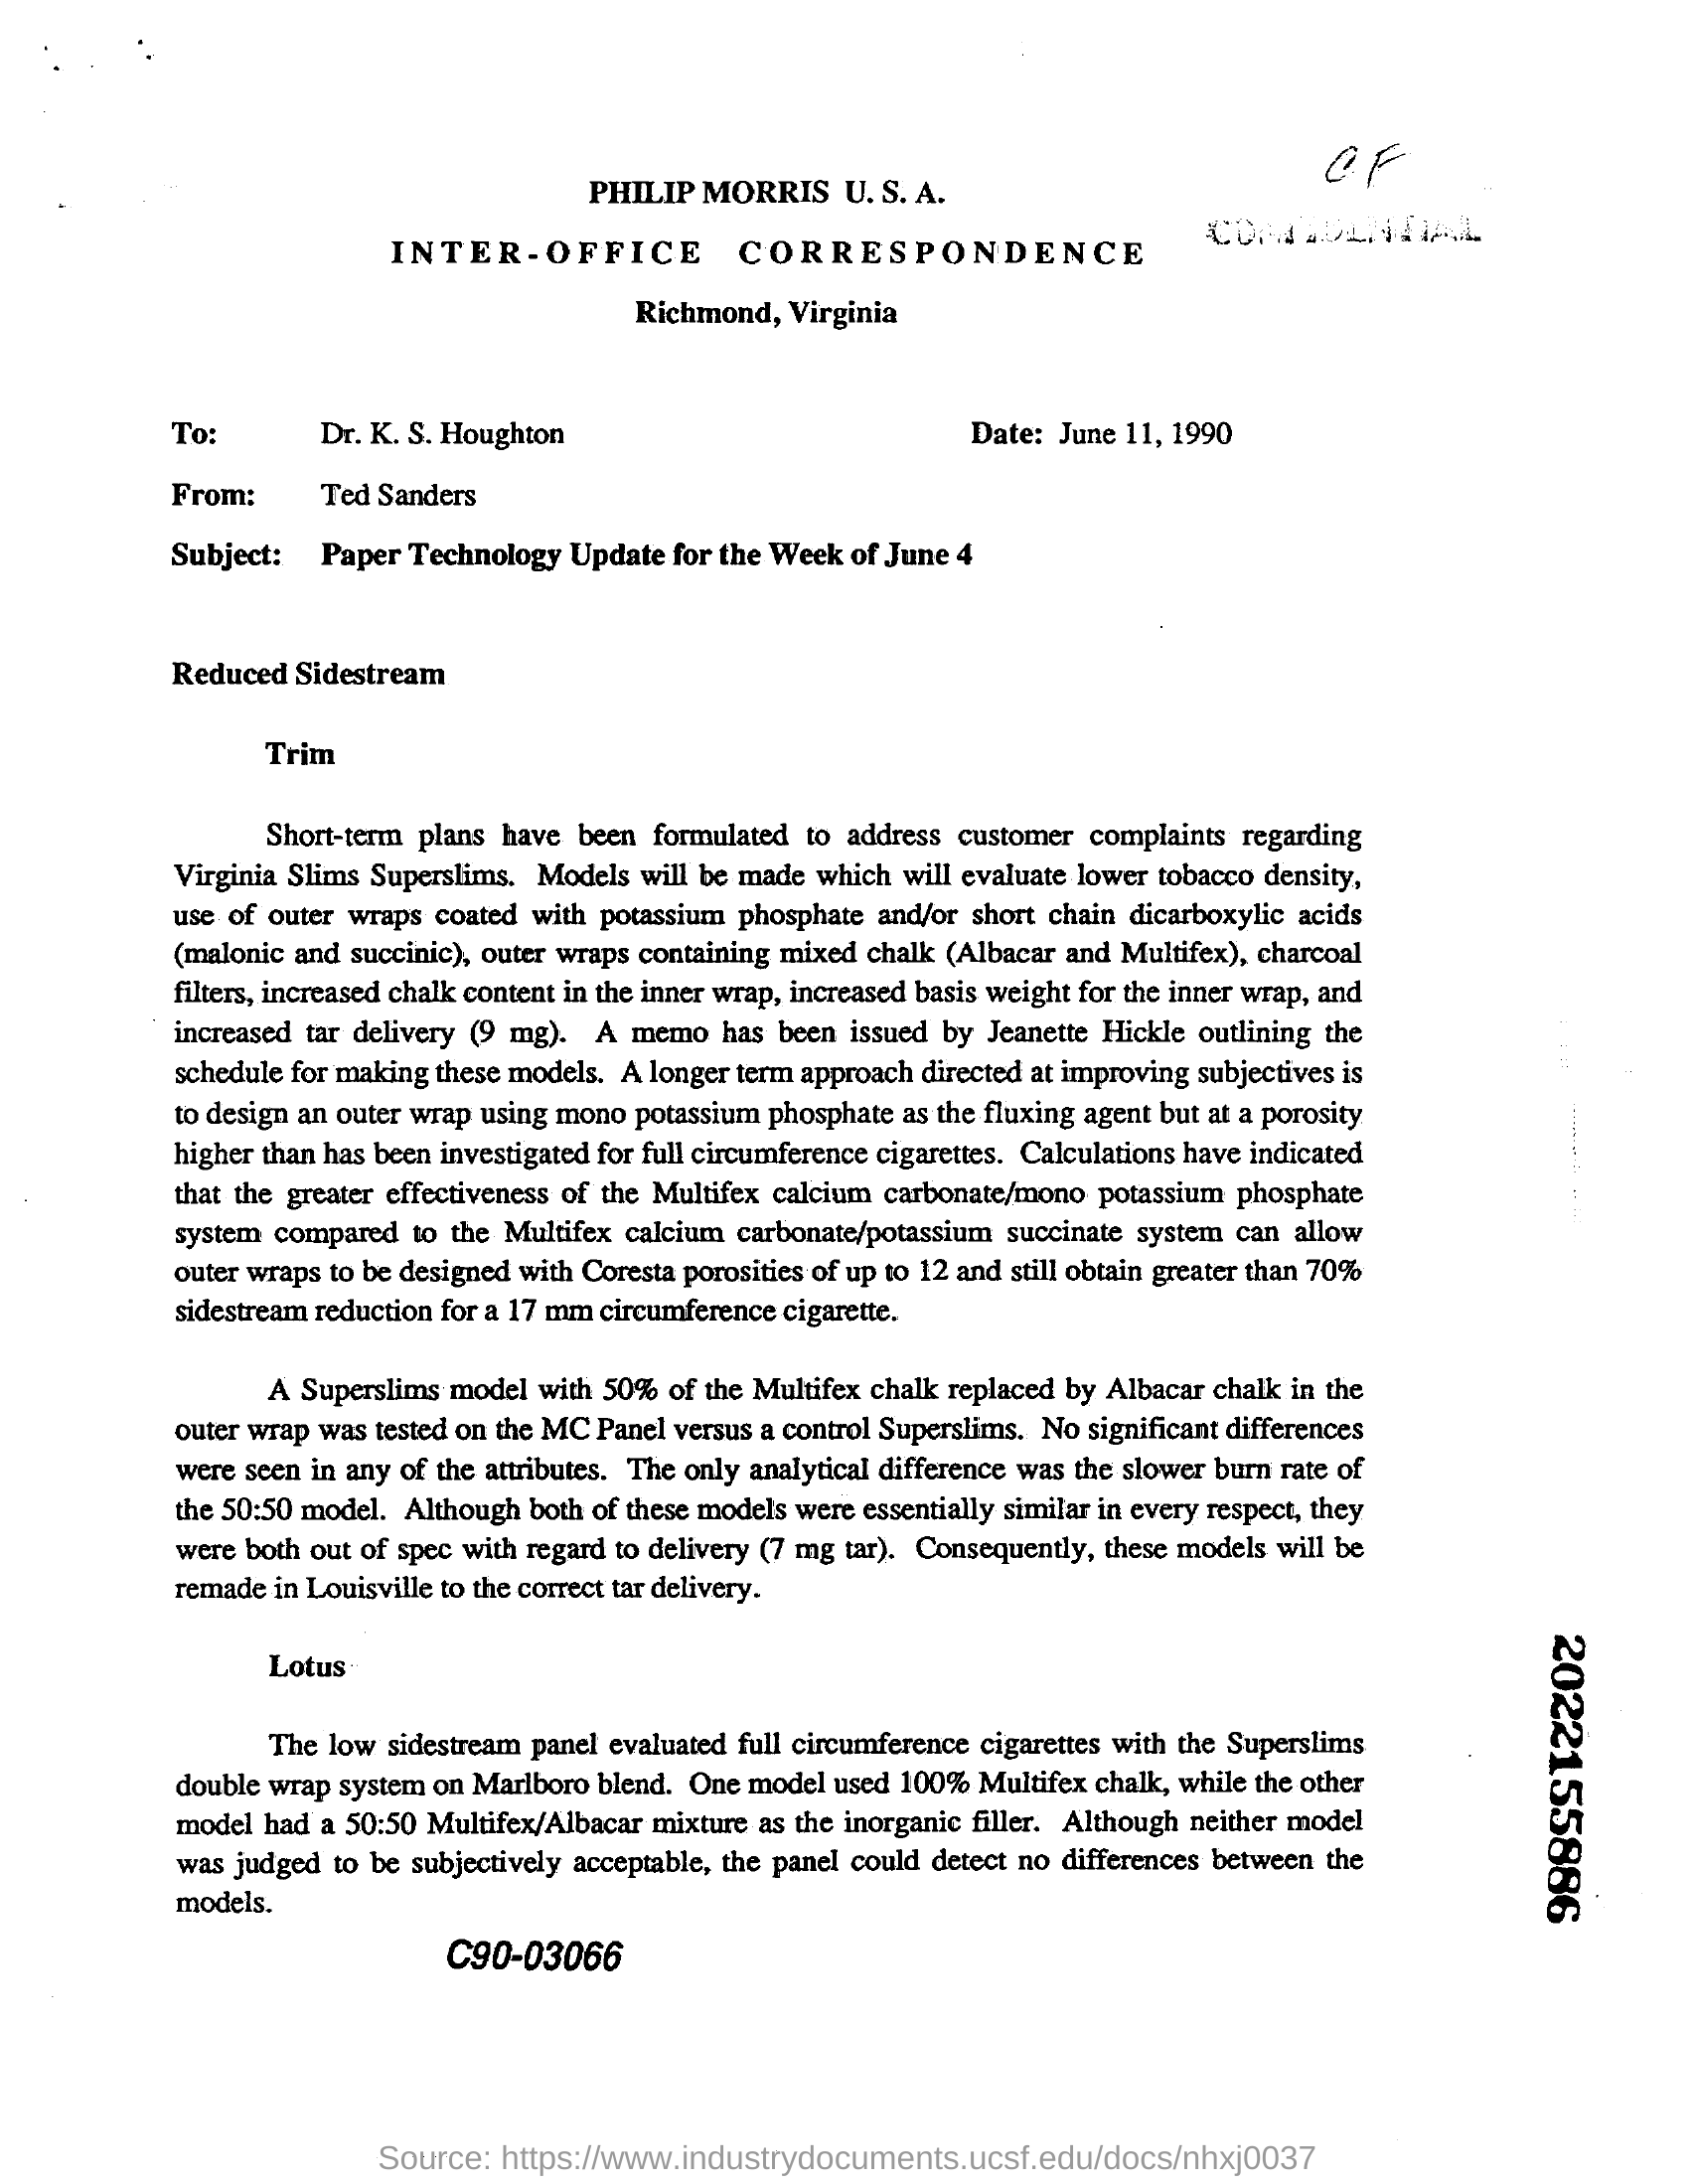

In [ ]:
image

In [ ]:
result

'Richmond'

### b. Model

In [ ]:
prompt

'<DocVQA>Which part of Virginia is this letter sent from'

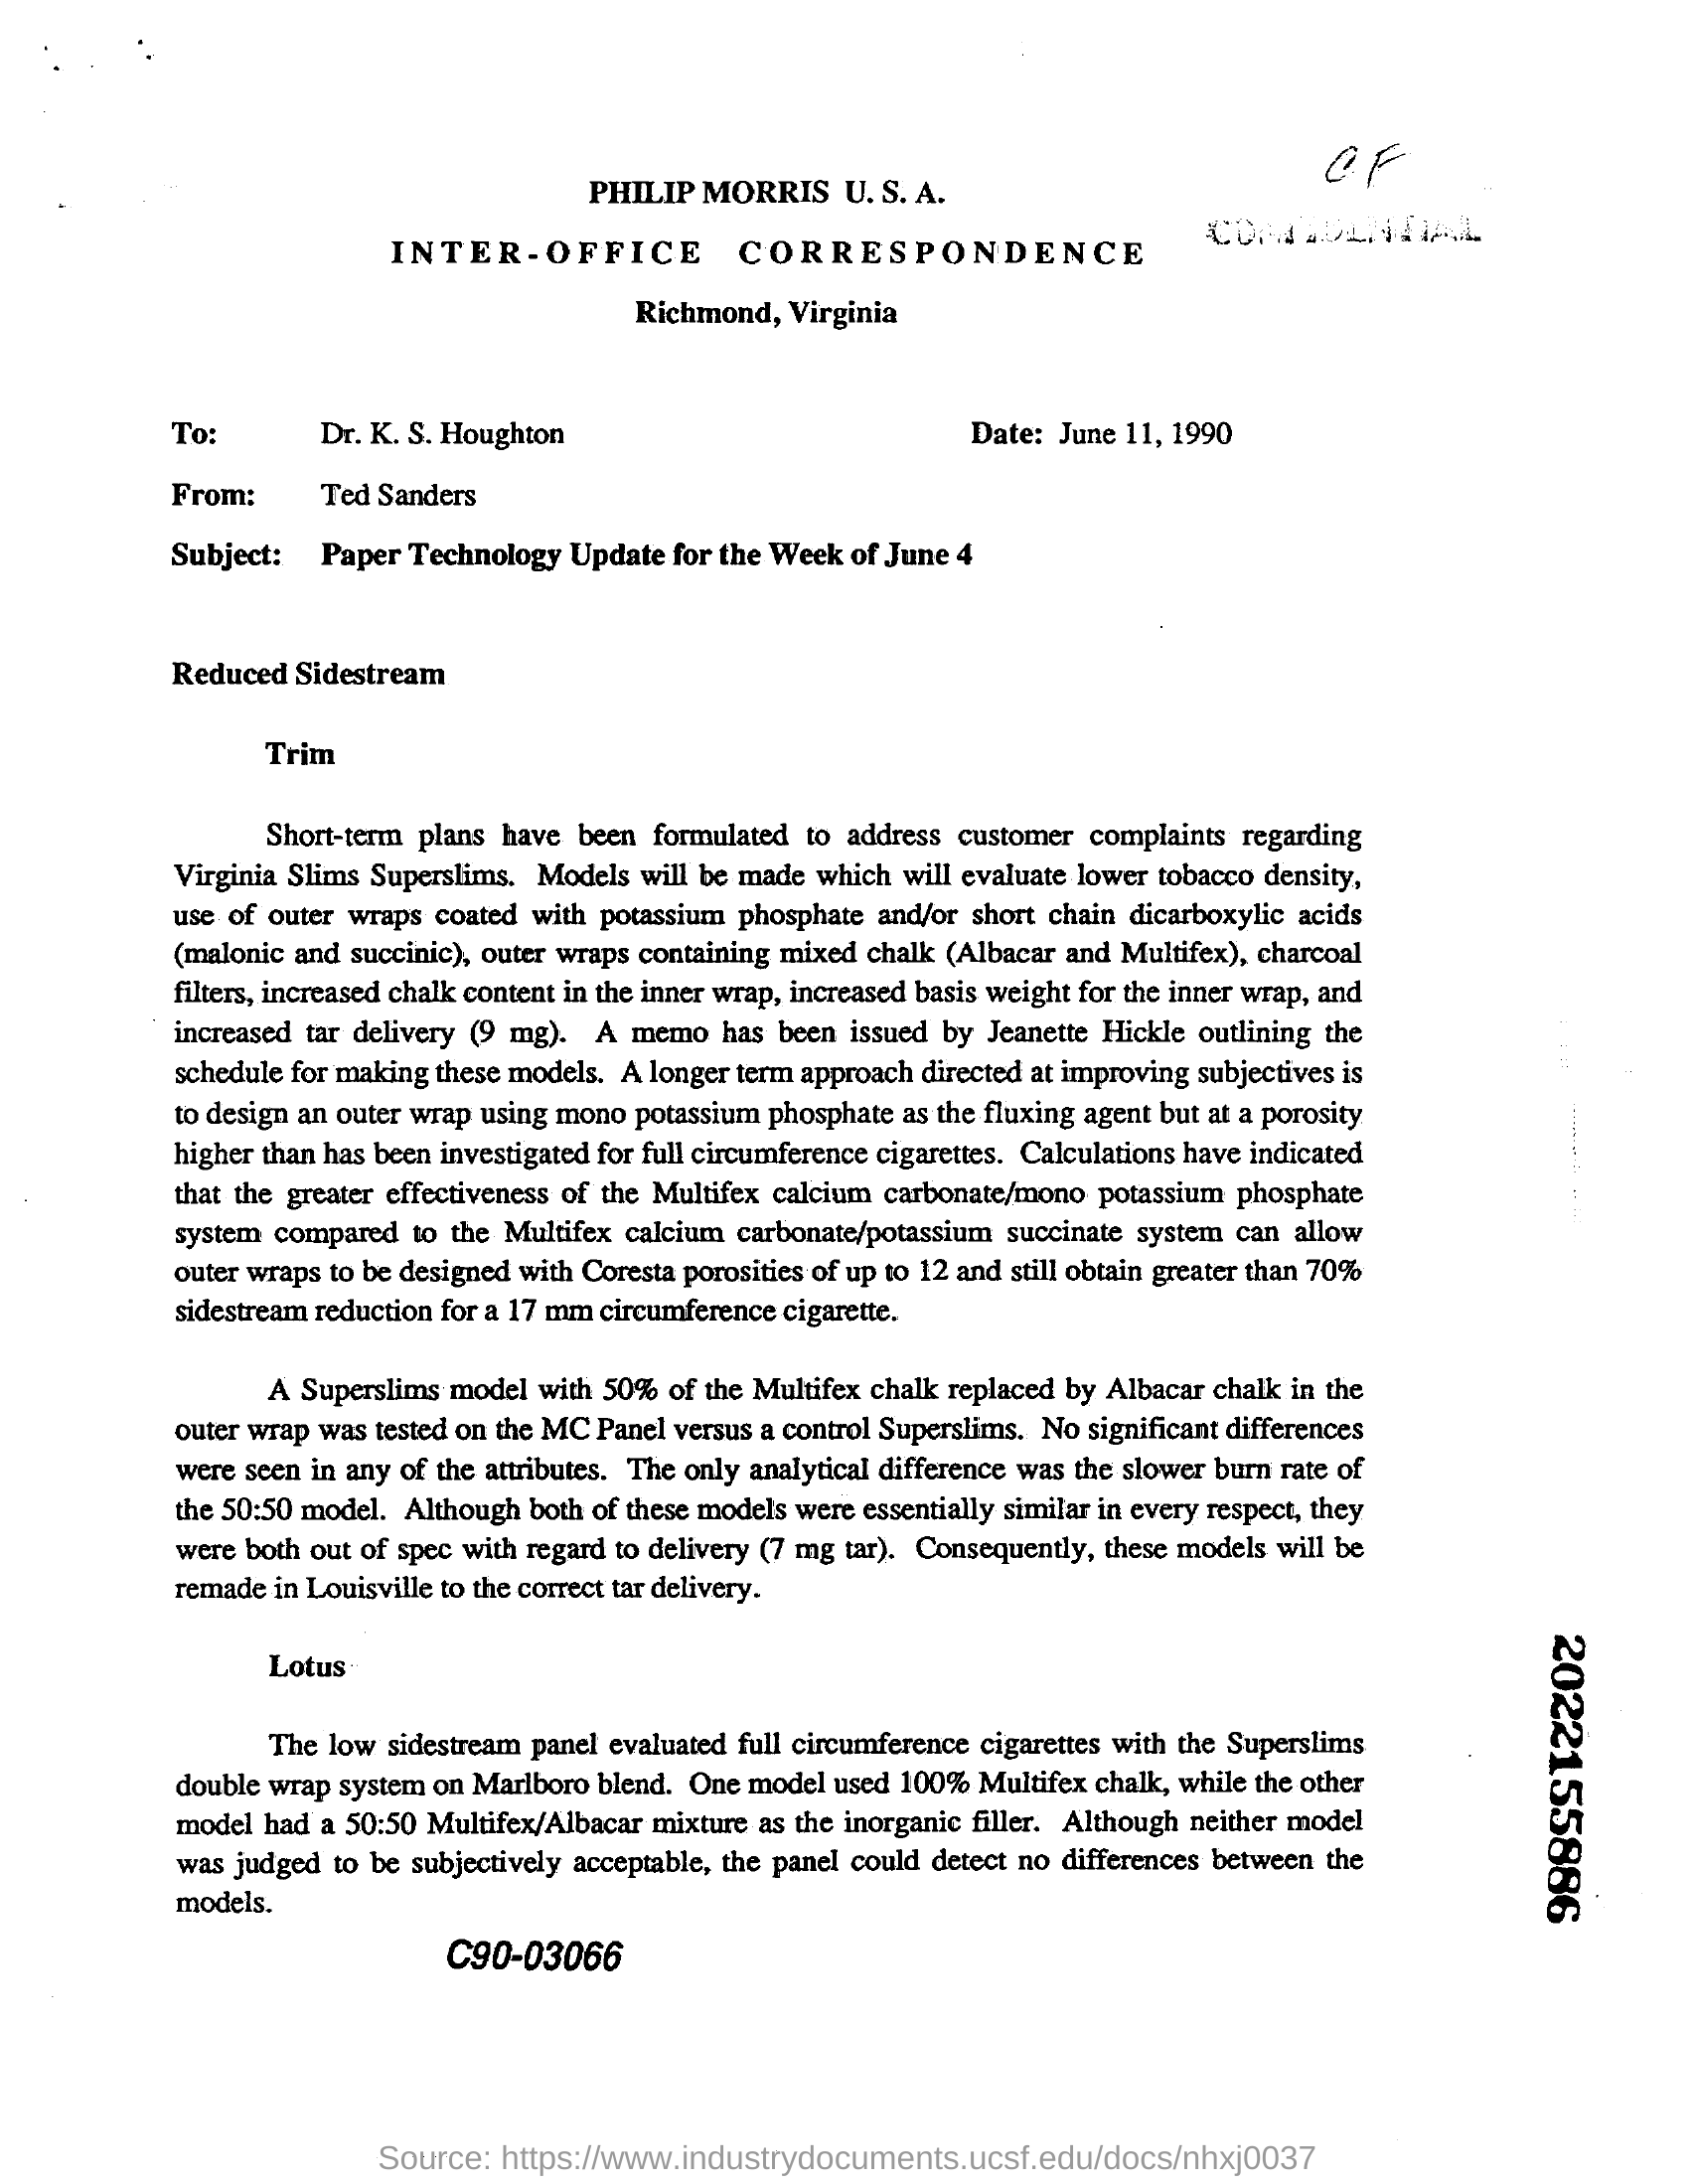

In [ ]:
image

In [ ]:
parsed_answer["<DocVQA>"]

'docvQA'

# 8. Training

In [ ]:
epochs = 7
optimizer = AdamW(model.parameters(), lr=1e-6)
num_training_steps = epochs * len(train_loader)

lr_scheduler = get_scheduler(name="linear", optimizer=optimizer,
                              num_warmup_steps=0, num_training_steps=num_training_steps,)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
for epoch in range(epochs):
    model.train()
    train_loss = 0
    i = -1
    for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
        i += 1
        input_ids = inputs["input_ids"]
        pixel_values = inputs["pixel_values"]
        labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)
        outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        train_loss += loss.item()
    avg_train_loss = train_loss / len(train_loader)
    avg_train_loss = round(avg_train_loss, 2)
    print(f"Average Training Loss: {avg_train_loss}")

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
            inputs, answers = batch
            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)
            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    avg_val_loss = round(avg_val_loss, 2)
    print(f"Average Validation Loss: {avg_val_loss}")
    print('-'*70)


Training Epoch 1/7: 100%|██████████| 167/167 [03:58<00:00,  1.43s/it]


Average Training Loss: 5.65


Validation Epoch 1/7: 100%|██████████| 67/67 [01:11<00:00,  1.07s/it]


Average Validation Loss: 3.64
----------------------------------------------------------------------


Training Epoch 2/7: 100%|██████████| 167/167 [03:57<00:00,  1.42s/it]


Average Training Loss: 3.75


Validation Epoch 2/7: 100%|██████████| 67/67 [01:11<00:00,  1.06s/it]


Average Validation Loss: 2.8
----------------------------------------------------------------------


Training Epoch 3/7: 100%|██████████| 167/167 [03:57<00:00,  1.42s/it]


Average Training Loss: 2.98


Validation Epoch 3/7: 100%|██████████| 67/67 [01:11<00:00,  1.06s/it]


Average Validation Loss: 2.33
----------------------------------------------------------------------


Training Epoch 4/7: 100%|██████████| 167/167 [03:57<00:00,  1.42s/it]


Average Training Loss: 2.49


Validation Epoch 4/7: 100%|██████████| 67/67 [01:11<00:00,  1.07s/it]


Average Validation Loss: 2.01
----------------------------------------------------------------------


Training Epoch 5/7: 100%|██████████| 167/167 [03:56<00:00,  1.42s/it]


Average Training Loss: 2.14


Validation Epoch 5/7: 100%|██████████| 67/67 [01:11<00:00,  1.07s/it]


Average Validation Loss: 1.82
----------------------------------------------------------------------


Training Epoch 6/7: 100%|██████████| 167/167 [03:57<00:00,  1.42s/it]


Average Training Loss: 1.94


Validation Epoch 6/7: 100%|██████████| 67/67 [01:11<00:00,  1.07s/it]


Average Validation Loss: 1.71
----------------------------------------------------------------------


Training Epoch 7/7: 100%|██████████| 167/167 [03:56<00:00,  1.42s/it]


Average Training Loss: 1.82


Validation Epoch 7/7: 100%|██████████| 67/67 [01:11<00:00,  1.06s/it]

Average Validation Loss: 1.68
----------------------------------------------------------------------


# 9. Inference

### a. Object Detection

In [ ]:
prompt = "<OD>"

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

In [ ]:
inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)

In [ ]:
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    do_sample=False,
    num_beams=3
)

In [ ]:
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

In [ ]:
parsed_answer = processor.post_process_generation(generated_text, task="<OD>", image_size=(image.width, image.height))

In [ ]:
print(parsed_answer)

{'<OD>': {'bboxes': [[34.880001068115234, 160.55999755859375, 598.0800170898438, 371.7599792480469], [453.44000244140625, 276.7200012207031, 554.5599975585938, 370.79998779296875], [93.75999450683594, 280.0799865722656, 198.0800018310547, 371.2799987792969]], 'labels': ['car', 'wheel', 'wheel']}}


In [ ]:
all_bb = parsed_answer['<OD>']['bboxes']
all_labels = parsed_answer['<OD>']['labels']

In [ ]:
plot_bb = []

for i in range(len(all_bb)):

  bb = all_bb[i]

  x_1 = bb[0]
  y_1 = bb[1]
  x_2 = bb[2]
  y_2 = bb[3]

  x = x_1
  y = y_1

  w = x_2 - x_1
  h = y_2 - y_1

  label = all_labels[i]

  bb_p = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor='r', facecolor='none')

  plot_bb.append(bb_p)

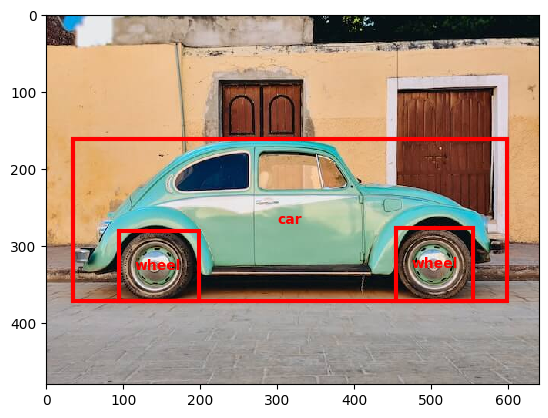

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(111)

ax.imshow(image, cmap = plt.cm.gray, interpolation ='nearest')

for i in range(len(plot_bb)):

  p_bb = plot_bb[i]

  bb = all_bb[i]

  x_1 = bb[0]
  y_1 = bb[1]
  x_2 = bb[2]
  y_2 = bb[3]

  cx = int((x_1 + x_2)/2)
  cy = int((y_1 + y_2)/2)

  ax.add_patch(p_bb)

  ax.annotate(all_labels[i], (cx, cy), color='red', weight='bold', fontsize=10, ha='center', va='center')

plt.show()

# 10. See example

In [ ]:
idx = 10

In [ ]:
prompt = train_dataset[idx][0]
image = train_dataset[idx][2]
result = train_dataset[idx][1]

In [ ]:
prompt

'<DocVQA>Which part of Virginia is this letter sent from'

In [ ]:
inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)

In [ ]:
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    do_sample=False,
    num_beams=3
)

In [ ]:
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

In [ ]:
parsed_answer = processor.post_process_generation(generated_text, task="<DocVQA>", image_size=(image.width, image.height))

In [ ]:
print(parsed_answer)

{'<DocVQA>': 'Richmond, Virginia'}


### a. Ground Truth

In [ ]:
prompt

'<DocVQA>Which part of Virginia is this letter sent from'

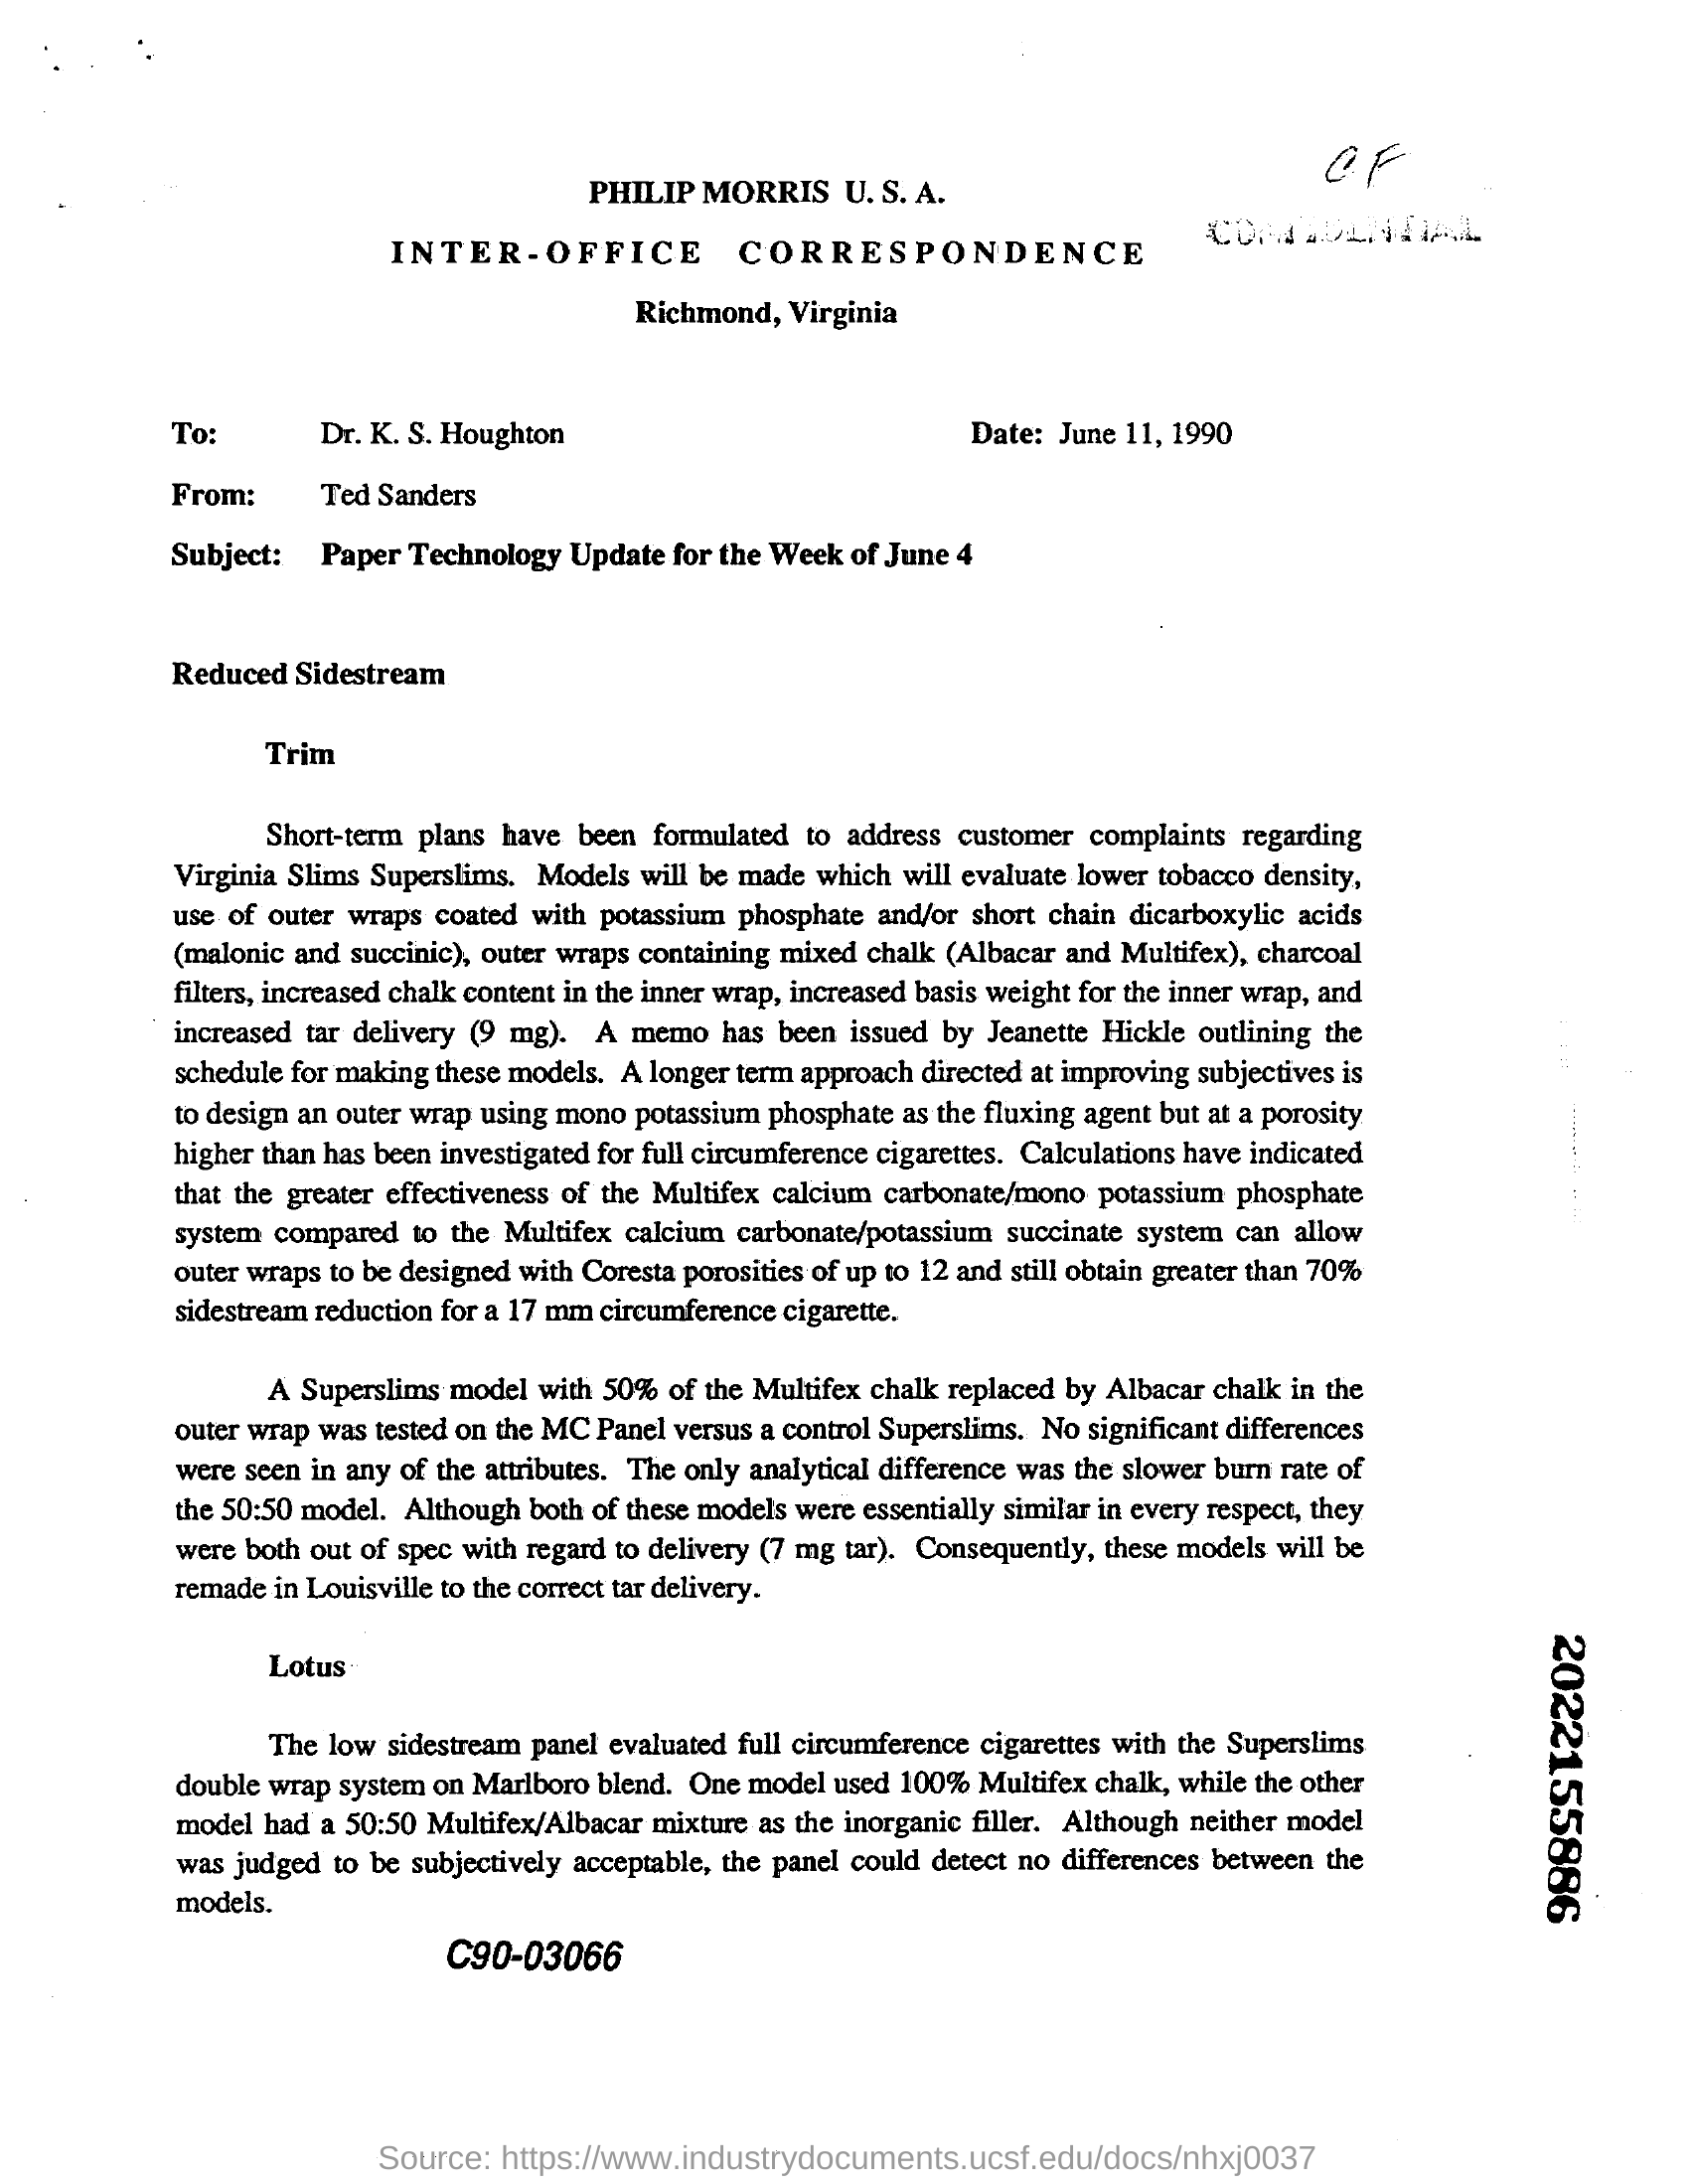

In [ ]:
image

In [ ]:
result

'Richmond'

### b. Model

In [ ]:
prompt

'<DocVQA>Which part of Virginia is this letter sent from'

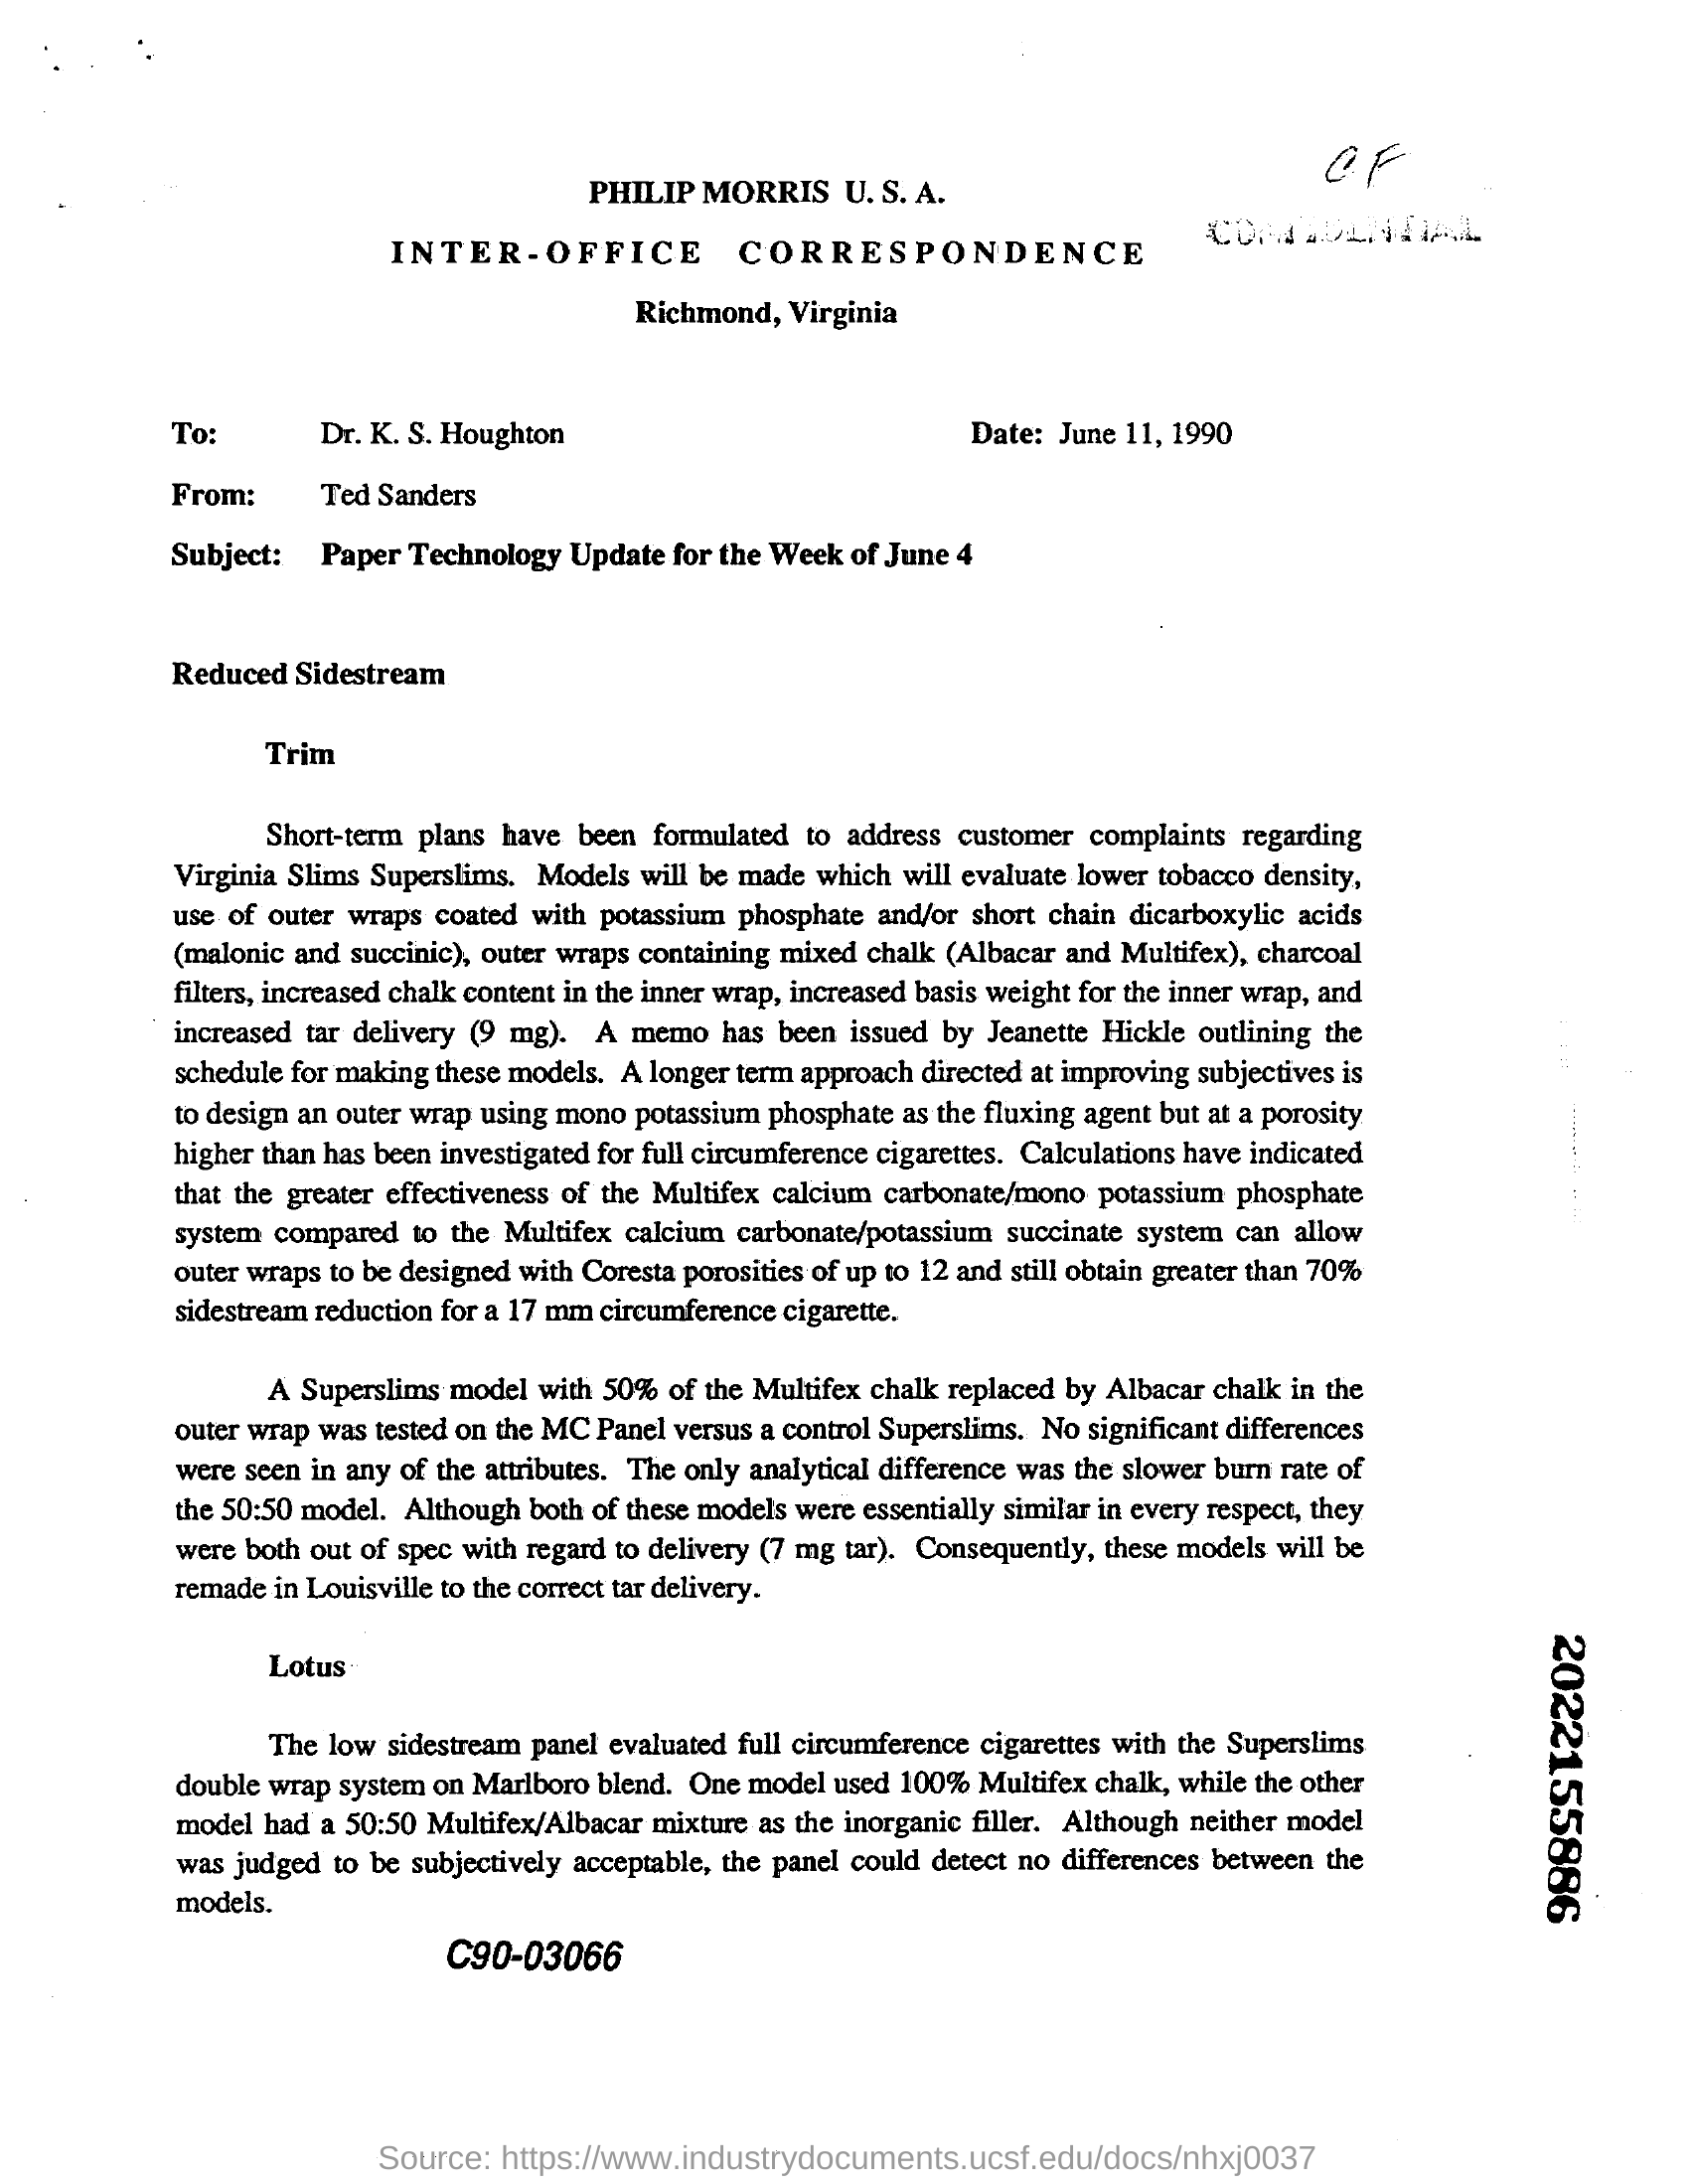

In [ ]:
image

In [ ]:
parsed_answer["<DocVQA>"]

'Richmond, Virginia'

### End of execution

In [ ]:
end = time.time()

delta = (end - start)

hours = int(delta/3_600)
mins = int((delta - hours*3_600)/60)
secs = int(delta - hours*3_600 - mins*60)

print(f'Hours: {hours}, Minutes: {mins}, Seconds: {secs}')

Hours: 0, Minutes: 36, Seconds: 30
